In [1]:
from pathlib import Path

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using: {device}")

using: cuda


In [3]:
img_size = 784
img_shape = (28, 28)

In [4]:
def one_hot(n, i):
    q = np.zeros(n)
    q[i] = 1.0
    return q


class MNISTDataset(Dataset):
    def __init__(self, fp):

        xy = np.loadtxt(fp, delimiter=',', dtype=np.float32)

        self.x = torch.from_numpy(xy[:, 1:])
        self.x = self.x / 255.0

        labels = []
        for i in xy[:, 0]:
            labels.append(one_hot(10, int(i)))

        self.y = torch.from_numpy(np.array(labels))
        self.n_samples = xy.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.n_samples

In [5]:
train_dataset = MNISTDataset(Path('/content/sample_data/mnist_train_small.csv'))
test_dataset = MNISTDataset(Path('/content/sample_data/mnist_test.csv'))

In [6]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

In [65]:
class Perceptron(nn.Module):
    def __init__(self, n_in, n_hidden):
        super().__init__()

        self.n_in = n_in
        self.n_hidden = n_hidden

        self.flatten = nn.Flatten()
        self.encoder = nn.Linear(self.n_in, self.n_hidden)
        self.act = nn.Sigmoid()
        self.decoder = nn.Linear(self.n_hidden, self.n_in)

    def forward(self, x):
        x = self.flatten(x)
        h = self.encoder(x)
        h = self.act(h)
        y = self.decoder(h)
        return y

In [66]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    for (x, y) in dataloader:
        x = x.to(device)

        x_hat = model(x)

        loss = loss_fn(x_hat, x)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

In [67]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    nbatches = len(dataloader)

    model.eval()

    loss = 0

    with torch.no_grad():
        for (x, y) in dataloader:
            x = x.to(device)

            x_hat = model(x)

            loss += loss_fn(x_hat, x).item()

    return loss / nbatches

In [118]:
n_epoch = 16
learn_ing_rate = 1e-2

In [119]:
n_in = 784
n_hidden = 16

model = Perceptron(n_in, n_hidden).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [120]:
for i in range(n_epoch):
    train(train_dataloader, model, loss_fn, optimizer)
    loss = test(test_dataloader, model, loss_fn)
    print(f"Epoch: {i+1:<3}| loss: {round(loss, 3):<6}")

Epoch: 1  | loss: 0.065 
Epoch: 2  | loss: 0.058 
Epoch: 3  | loss: 0.051 
Epoch: 4  | loss: 0.045 
Epoch: 5  | loss: 0.042 
Epoch: 6  | loss: 0.039 
Epoch: 7  | loss: 0.036 
Epoch: 8  | loss: 0.034 
Epoch: 9  | loss: 0.033 
Epoch: 10 | loss: 0.032 
Epoch: 11 | loss: 0.031 
Epoch: 12 | loss: 0.03  
Epoch: 13 | loss: 0.03  
Epoch: 14 | loss: 0.029 
Epoch: 15 | loss: 0.029 
Epoch: 16 | loss: 0.029 


In [109]:
def range_normalize(x: np.ndarray, a: float, b: float) -> np.ndarray:
    return a + (b - a) * (x - np.min(x)) / (np.max(x) - np.min(x))

In [124]:
encoder_weights = model.encoder.weight.cpu().detach().numpy()
decoder_weights = model.decoder.weight.cpu().detach().numpy().T

print(encoder_weights.shape)
print(decoder_weights.shape)

(16, 784)
(16, 784)


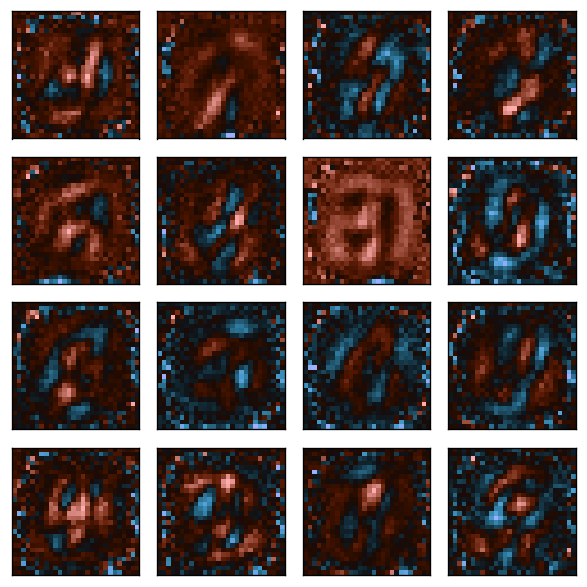

In [126]:
fig, axes = plt.subplots(nrows=4, ncols=4)

fig.set_figwidth(5)
fig.set_figheight(5)
fig.set_dpi(120)

for i, ax in enumerate(axes.ravel()):
    w = range_normalize(encoder_weights[i], -1, 1)
    ax.imshow(w.reshape(img_shape), cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

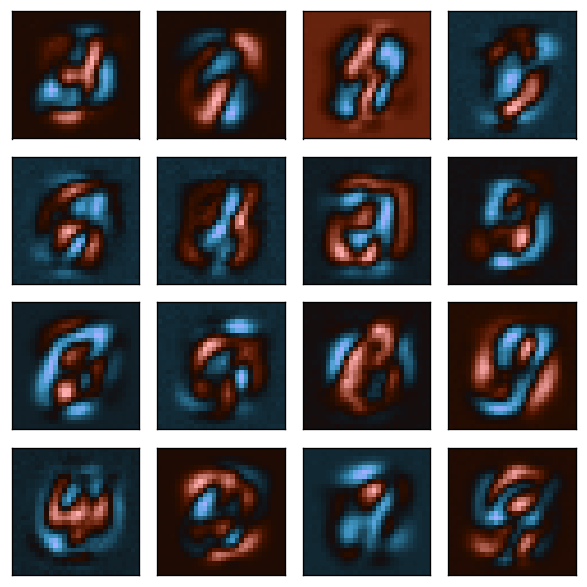

In [127]:
fig, axes = plt.subplots(nrows=4, ncols=4)

fig.set_figwidth(5)
fig.set_figheight(5)
fig.set_dpi(120)

for i, ax in enumerate(axes.ravel()):
    w = range_normalize(decoder_weights[i], -1, 1)
    ax.imshow(w.reshape(img_shape), cmap='berlin')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()